In [82]:
import sys
sys.path.append('..')
from CuriousAFL.rnd import RND
import os
import numpy as np
import torch
import seaborn as sb
import random
from tqdm import tqdm
from collections import deque

# epochs are controlled by AFL
retrain_every_x_seeds = 10**2

max_filesize = 2**8
learning_rate = 1e-4

rnd_model = None
#random sample of files to retrain model

input_dim = max_filesize
output_dim = 2 #fuzz or don't - 2 possible actions

batch_size = 128 # TODO: WHY?
replay_buffer = deque(maxlen=64) 


In [2]:
seed_dir = '../test/neuzz_in/'
seeds = os.listdir(seed_dir)

In [3]:

def vectorize(input_file):

    shape = np.zeros(shape=(max_filesize, 8))

    with open(input_file, "rb") as f:
        byte = f.read(1)
        byte_pos = 0
        print(byte)
        while byte:
            bits = bin(int.from_bytes(byte, byteorder="big"))[2:].zfill(8)
           
            for n, bit in enumerate(bits):
                if bit == '1':
                    shape[byte_pos, n] = 1.
            break
            byte = f.read(1)
            byte_pos += 1

    return shape


In [4]:
from mmap import ACCESS_READ, mmap

with open('./initial_seeds/' + seeds[0], 'rb', 0) as f, mmap(f.fileno(), 0, access=ACCESS_READ) as s:
    arr = s

In [83]:
rnd_model = RND(in_dim=input_dim, out_dim=1, n_hid=int(input_dim/8))

In [84]:
step_counter = 0
rewards = []

for seed in seeds:
    #convert file into byte-array
    byte_array = np.fromfile(seed_dir + seed, 'u1')
    byte_array = byte_array / 255 # min max normalized
    #byte_array = vectorize
    
    if len(byte_array)>max_filesize:
        byte_array = byte_array[:max_filesize]
    else:
        byte_array = np.pad(byte_array, (0, max_filesize - len(byte_array)), 'constant', 
                            constant_values=0)
    
    #get internal reward
    state = torch.Tensor(byte_array) #.unsqueeze(0)
    
    reward_i = rnd_model.get_reward(state).detach().clamp(0.0,1.0).item()
    #reward_i = rnd_model.get_reward(state).item()
    
    replay_buffer.append(byte_array)
    rewards.append(reward_i)
    
    
    step_counter += 1
    
    if step_counter > batch_size:
        #update model
        num = len(replay_buffer)
        K = np.min([num, batch_size])
        samples = random.sample(replay_buffer, K)
        
        S0 = torch.tensor(samples, dtype=torch.float)
        
        Ri = rnd_model.get_reward(S0)
        rnd_model.update(Ri)
        
        #print('updated model')
        step_counter = 0
    

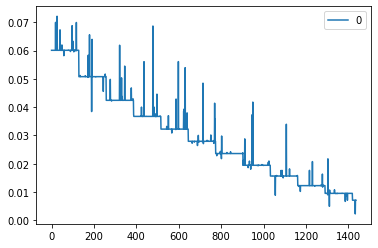

In [86]:
import pandas as pd
df = pd.DataFrame(rewards)
sb.lineplot(data=df)

In [77]:
len(df.loc[df[0] < 0.5])

1433

In [33]:
len(df)

1436

In [11]:
len(np.fromfile('./initial_seeds/' + seeds[0], 'u1'))

7304

In [45]:
byte_array = np.fromfile('./initial_seeds/' + seeds[0], 'u1')
byte_array

array([127,  69,  76, ...,   0,   0,   0], dtype=uint8)